# GHG HLM on Scope 3 source Downstream Transportation

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_log_error, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GroupShuffleSplit
from scipy.stats import zscore
import scipy.stats as stats
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
import warnings
from statsmodels.regression.mixed_linear_model import MixedLM


#read in dataset from GHG_post_outliers data set
downstream=pd.read_csv('/Users/amberjensen/Desktop/GHG_Emissions_Project/downstream.csv')

In [2]:
#check for info
downstream.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2481 entries, 0 to 2480
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   account_name                2481 non-null   object 
 1   account_id                  2481 non-null   int64  
 2   Year                        2481 non-null   int64  
 3   incorporated_country        2481 non-null   object 
 4   Primary activity            2481 non-null   object 
 5   Primary sector              2481 non-null   object 
 6   Market_Cap_USD              1999 non-null   float64
 7   Third_party_verification    2481 non-null   object 
 8   Revenue_USD                 2015 non-null   float64
 9   ebitda_USD                  2015 non-null   float64
 10  grossProfit_USD             2015 non-null   float64
 11  netIncome_USD               2015 non-null   float64
 12  cashAndCashEquivalents_USD  2015 non-null   float64
 13  shortTermInvestments_USD    2015 

In [3]:
#show a df for downstream
downstream.head()

,account_name,account_id,Year,incorporated_country,Primary activity,Primary sector,Market_Cap_USD,Third_party_verification,Revenue_USD,ebitda_USD,...,longTermInvestments_USD,totalAssets_USD,totalLiabilities_USD,totalInvestments_USD,totalDebt_USD,totalEquity_USD,Scope_3_emissions_type,Scope_3_emissions_amount,scope_1_2_emissions_amount,Year_sq
0,Antofagasta,820,2018,United Kingdom,Other non-ferrous ore mining,Metallic mineral mining,7.721230e+09,Third-party verification or assurance process ...,4.733100e+09,2.092800e+09,...,1.060800e+09,1.410250e+10,4.664400e+09,1.924000e+09,2.493900e+09,9.438100e+09,Downstream transportation and distribution,2796.0,3.292186e+06,4072324
1,Aptiv,4407,2018,United Kingdom,Electrical equipment,Electrical & electronic equipment,1.595156e+10,No third-party verification or assurance,1.443500e+10,2.260000e+09,...,9.900000e+07,1.248000e+10,8.810000e+09,1.710000e+08,4.344000e+09,3.670000e+09,Downstream transportation and distribution,237690.0,3.804718e+05,4072324
2,AstraZeneca,1104,2018,United Kingdom,Pharmaceuticals,Biotech & pharma,7.441091e+10,Third-party verification or assurance process ...,2.209000e+10,7.165000e+09,...,1.130000e+08,6.065100e+10,4.660700e+10,9.220000e+08,1.911300e+10,1.404400e+10,Downstream transportation and distribution,318080.0,7.072529e+05,4072324
3,Britvic,2280,2018,United Kingdom,Non-alcoholic beverages,Food & beverage processing,2.702902e+09,Third-party verification or assurance process ...,1.909572e+09,2.719070e+08,...,5.118100e+07,2.235708e+09,1.756537e+09,9.728200e+07,9.767570e+08,4.791710e+08,Downstream transportation and distribution,54149.0,4.579525e+04,4072324
4,Bunzl plc,2412,2018,United Kingdom,"Dealers, wholesalers & distributors","Trading, wholesale, distribution, rental & lea...",1.007031e+10,No third-party verification or assurance,1.153084e+10,8.074660e+08,...,7.493000e+06,7.056247e+09,4.904232e+09,7.493000e+06,2.368169e+09,2.152015e+09,Downstream transportation and distribution,78724.0,1.076858e+05,4072324


In [4]:
#define a list of numeric columns
numeric_cols = ['Market_Cap_USD', 'Revenue_USD', 'ebitda_USD',
       'grossProfit_USD', 'netIncome_USD', 'cashAndCashEquivalents_USD',
       'shortTermInvestments_USD', 'longTermInvestments_USD',
       'totalAssets_USD', 'totalLiabilities_USD', 'totalInvestments_USD',
       'totalDebt_USD', 'totalEquity_USD', 'Scope_3_emissions_amount', 'scope_1_2_emissions_amount']

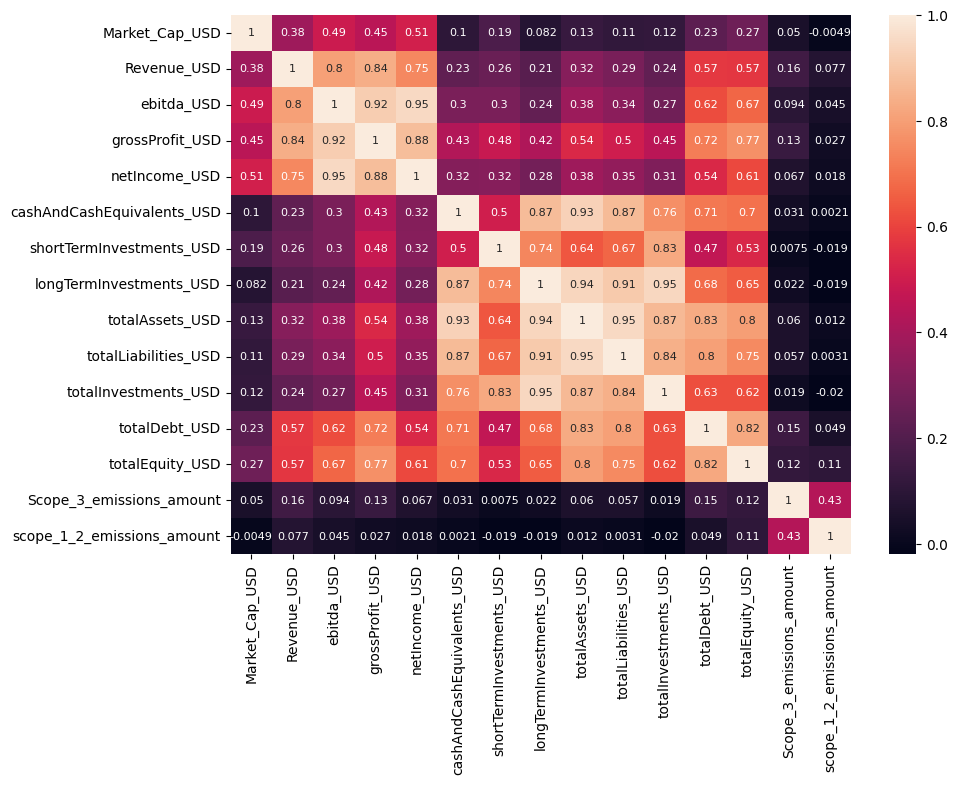

In [5]:
#plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(downstream[numeric_cols].corr(), annot=True, annot_kws={"size": 8})
plt.show()

In [6]:
#correlation matrix
downstream[numeric_cols].corr()

,Market_Cap_USD,Revenue_USD,ebitda_USD,grossProfit_USD,netIncome_USD,cashAndCashEquivalents_USD,shortTermInvestments_USD,longTermInvestments_USD,totalAssets_USD,totalLiabilities_USD,totalInvestments_USD,totalDebt_USD,totalEquity_USD,Scope_3_emissions_amount,scope_1_2_emissions_amount
Market_Cap_USD,1.000000,0.382476,0.490246,0.448495,0.509520,0.101232,0.187184,0.081999,0.128392,0.113073,0.117095,0.226503,0.270115,0.049549,-0.004850
Revenue_USD,0.382476,1.000000,0.804582,0.839906,0.748388,0.233177,0.255759,0.214120,0.323074,0.294937,0.236893,0.573947,0.572999,0.155515,0.077170
ebitda_USD,0.490246,0.804582,1.000000,0.919630,0.949995,0.297741,0.296422,0.242434,0.376465,0.337302,0.272882,0.621074,0.673182,0.094229,0.045358
grossProfit_USD,0.448495,0.839906,0.919630,1.000000,0.879359,0.426680,0.479326,0.418945,0.536235,0.500973,0.448366,0.723368,0.765210,0.134714,0.026554
netIncome_USD,0.509520,0.748388,0.949995,0.879359,1.000000,0.321071,0.324601,0.281506,0.379856,0.351659,0.307382,0.535545,0.612565,0.067301,0.018070
cashAndCashEquivalents_USD,0.101232,0.233177,0.297741,0.426680,0.321071,1.000000,0.503707,0.872903,0.930156,0.868731,0.763990,0.709855,0.697038,0.030581,0.002085
shortTermInvestments_USD,0.187184,0.255759,0.296422,0.479326,0.324601,0.503707,1.000000,0.741592,0.640836,0.671149,0.827591,0.465738,0.531795,0.007470,-0.019245
longTermInvestments_USD,0.081999,0.214120,0.242434,0.418945,0.281506,0.872903,0.741592,1.000000,0.943691,0.912015,0.945725,0.684532,0.652718,0.021864,-0.018950
totalAssets_USD,0.128392,0.323074,0.376465,0.536235,0.379856,0.930156,0.640836,0.943691,1.000000,0.949646,0.865488,0.830886,0.799573,0.059759,0.011552
totalLiabilities_USD,0.113073,0.294937,0.337302,0.500973,0.351659,0.868731,0.671149,0.912015,0.949646,1.000000,0.841856,0.803833,0.749189,0.057451,0.003097


In [7]:
#drop columns due to collinearity, keeping total
downstream=downstream.drop(columns=['grossProfit_USD', 'netIncome_USD', 'cashAndCashEquivalents_USD',
    'shortTermInvestments_USD', 'longTermInvestments_USD', "account_name", "Third_party_verification", "Scope_3_emissions_type"])

In [8]:
downstream.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2481 entries, 0 to 2480
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   account_id                  2481 non-null   int64  
 1   Year                        2481 non-null   int64  
 2   incorporated_country        2481 non-null   object 
 3   Primary activity            2481 non-null   object 
 4   Primary sector              2481 non-null   object 
 5   Market_Cap_USD              1999 non-null   float64
 6   Revenue_USD                 2015 non-null   float64
 7   ebitda_USD                  2015 non-null   float64
 8   totalAssets_USD             2015 non-null   float64
 9   totalLiabilities_USD        2015 non-null   float64
 10  totalInvestments_USD        2015 non-null   float64
 11  totalDebt_USD               2015 non-null   float64
 12  totalEquity_USD             2015 non-null   float64
 13  Scope_3_emissions_amount    2481 

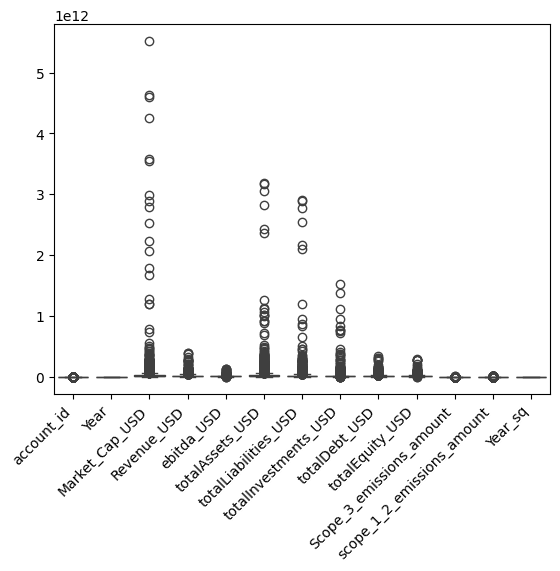

In [9]:
sns.boxplot(downstream)
plt.xticks(rotation=45, ha='right')
plt.show()

In [10]:
# copy dataframe
downstream_no_transform = downstream.copy()
# Change 'incorporated_country' to 'Countries' in downstream dataframe
downstream_no_transform = downstream_no_transform.rename(columns={'incorporated_country': 'Countries',
                                                       'Primary activity': 'Primary_activity',
                                                        'Primary sector': 'Primary_sector'})

print(downstream_no_transform.info())
downstream_no_transform.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2481 entries, 0 to 2480
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   account_id                  2481 non-null   int64  
 1   Year                        2481 non-null   int64  
 2   Countries                   2481 non-null   object 
 3   Primary_activity            2481 non-null   object 
 4   Primary_sector              2481 non-null   object 
 5   Market_Cap_USD              1999 non-null   float64
 6   Revenue_USD                 2015 non-null   float64
 7   ebitda_USD                  2015 non-null   float64
 8   totalAssets_USD             2015 non-null   float64
 9   totalLiabilities_USD        2015 non-null   float64
 10  totalInvestments_USD        2015 non-null   float64
 11  totalDebt_USD               2015 non-null   float64
 12  totalEquity_USD             2015 non-null   float64
 13  Scope_3_emissions_amount    2481 

,account_id,Year,Countries,Primary_activity,Primary_sector,Market_Cap_USD,Revenue_USD,ebitda_USD,totalAssets_USD,totalLiabilities_USD,totalInvestments_USD,totalDebt_USD,totalEquity_USD,Scope_3_emissions_amount,scope_1_2_emissions_amount,Year_sq
0,820,2018,United Kingdom,Other non-ferrous ore mining,Metallic mineral mining,7.721230e+09,4.733100e+09,2.092800e+09,1.410250e+10,4.664400e+09,1.924000e+09,2.493900e+09,9.438100e+09,2796.0,3.292186e+06,4072324
1,4407,2018,United Kingdom,Electrical equipment,Electrical & electronic equipment,1.595156e+10,1.443500e+10,2.260000e+09,1.248000e+10,8.810000e+09,1.710000e+08,4.344000e+09,3.670000e+09,237690.0,3.804718e+05,4072324
2,1104,2018,United Kingdom,Pharmaceuticals,Biotech & pharma,7.441091e+10,2.209000e+10,7.165000e+09,6.065100e+10,4.660700e+10,9.220000e+08,1.911300e+10,1.404400e+10,318080.0,7.072529e+05,4072324
3,2280,2018,United Kingdom,Non-alcoholic beverages,Food & beverage processing,2.702902e+09,1.909572e+09,2.719070e+08,2.235708e+09,1.756537e+09,9.728200e+07,9.767570e+08,4.791710e+08,54149.0,4.579525e+04,4072324
4,2412,2018,United Kingdom,"Dealers, wholesalers & distributors","Trading, wholesale, distribution, rental & lea...",1.007031e+10,1.153084e+10,8.074660e+08,7.056247e+09,4.904232e+09,7.493000e+06,2.368169e+09,2.152015e+09,78724.0,1.076858e+05,4072324


In [11]:
downstream_no_transform['Primary_sector'].value_counts()

Primary_sector
Electrical & electronic equipment                     348
Chemicals                                             263
Food & beverage processing                            219
Financial services                                    120
Biotech & pharma                                      115
Discretionary retail                                   82
Media, telecommunications & data center services       79
Convenience retail                                     79
Paper products & packaging                             77
Powered machinery                                      76
Trading, wholesale, distribution, rental & leasing     59
Wood & rubber products                                 46
Cement & concrete                                      44
Metal products manufacturing                           43
Metal smelting, refining & forming                     42
Metallic mineral mining                                42
Print & publishing services                            40

In [12]:
downstream_no_transform['Primary_activity'].value_counts().head(20)

Primary_activity
Electronic components                  134
Pharmaceuticals                         92
Personal care & household products      80
Supermarkets, food & drugstores         79
Banks                                   78
Paper products                          77
Other food processing                   75
Telecommunications services             72
Specialty chemicals                     70
Alcoholic beverages                     69
Other base chemicals                    66
Communications equipment                59
Electronic equipment                    54
Electrical equipment                    46
Dealers, wholesalers & distributors     46
Cement                                  40
Pulp & paper mills                      37
Rubber products                         34
CCGT generation                         33
Specialist retail                       32
Name: count, dtype: int64

In [13]:
# Looking at missing data
print(downstream_no_transform.isnull().mean().sort_values(ascending=False).round(3) * 100)

Market_Cap_USD                19.4
Revenue_USD                   18.8
ebitda_USD                    18.8
totalAssets_USD               18.8
totalLiabilities_USD          18.8
totalInvestments_USD          18.8
totalDebt_USD                 18.8
totalEquity_USD               18.8
scope_1_2_emissions_amount     0.1
account_id                     0.0
Year                           0.0
Countries                      0.0
Primary_activity               0.0
Primary_sector                 0.0
Scope_3_emissions_amount       0.0
Year_sq                        0.0
dtype: float64


Apply signed log transformation and split data by company and year into train_df (2018-2022) and test_df (2023):

In [14]:
numeric_cols = ['Market_Cap_USD', 'Revenue_USD', 'ebitda_USD',
       'totalAssets_USD', 'totalLiabilities_USD', 'totalInvestments_USD',
       'totalDebt_USD', 'totalEquity_USD', 'Scope_3_emissions_amount',
       'scope_1_2_emissions_amount'
]
required_cols = [
    'account_id', 'Year', 'Year_sq', 'Countries', 'Primary_activity', 'Primary_sector'
] + numeric_cols

# --- Prepare Data ---
df = downstream_no_transform[required_cols].dropna()

# --- Signed log transform ---
def signed_log(x):
    return np.sign(x) * np.log(np.abs(x) + 1)

for col in numeric_cols:
    df[f'slog_{col}'] = signed_log(df[col])

# --- Company-level split by year ---
train_df = df[df['Year'].between(2018, 2022)].copy()
test_df  = df[df['Year'] == 2023].copy()

# Keep only companies present in training
valid_companies = set(train_df['account_id'].unique())
test_df = test_df[test_df['account_id'].isin(valid_companies)].copy()

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (1630, 26)
Test shape: (303, 26)


In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1630 entries, 0 to 2035
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   account_id                       1630 non-null   int64  
 1   Year                             1630 non-null   int64  
 2   Year_sq                          1630 non-null   int64  
 3   Countries                        1630 non-null   object 
 4   Primary_activity                 1630 non-null   object 
 5   Primary_sector                   1630 non-null   object 
 6   Market_Cap_USD                   1630 non-null   float64
 7   Revenue_USD                      1630 non-null   float64
 8   ebitda_USD                       1630 non-null   float64
 9   totalAssets_USD                  1630 non-null   float64
 10  totalLiabilities_USD             1630 non-null   float64
 11  totalInvestments_USD             1630 non-null   float64
 12  totalDebt_USD            

In [16]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 303 entries, 2038 to 2479
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   account_id                       303 non-null    int64  
 1   Year                             303 non-null    int64  
 2   Year_sq                          303 non-null    int64  
 3   Countries                        303 non-null    object 
 4   Primary_activity                 303 non-null    object 
 5   Primary_sector                   303 non-null    object 
 6   Market_Cap_USD                   303 non-null    float64
 7   Revenue_USD                      303 non-null    float64
 8   ebitda_USD                       303 non-null    float64
 9   totalAssets_USD                  303 non-null    float64
 10  totalLiabilities_USD             303 non-null    float64
 11  totalInvestments_USD             303 non-null    float64
 12  totalDebt_USD          

In [17]:
# Check number of 0's in train and test df's
print((train_df == 0).sum().sum())
print((test_df == 0).sum().sum())

96
10


## Downstream Null Mixed-Effects Model

Null mixed-effects model (random intercept only) to predict log-transformed Scope 3 emissions. The model serves as a baseline, capturing only the average emission level for each company, without incorporating any explanatory variables, and quantifies the improvement gained by including additional features and structure. The model is trained on 2018–2022 data and evaluated on a test set from 2023.

Model Structure:
- Random Effects:
    - Random intercept for each company ('account_id'), capturing baseline differences between companies
- Fixed Effects:
    - Intercept only (no predictors)

                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_Scope_3_emissions_amount
No. Observations: 1630    Method:             REML                        
No. Groups:       434     Scale:              0.7767                      
Min. group size:  1       Log-Likelihood:     -2830.5834                  
Max. group size:  5       Converged:          Yes                         
Mean group size:  3.8                                                     
------------------------------------------------------------------------------
                Coef.      Std.Err.       z        P>|z|     [0.025     0.975]
------------------------------------------------------------------------------
Intercept       10.281        0.123     83.320     0.000     10.040     10.523
Group Var        6.325        0.597                                           

R²(log):    -0.19%
R²(orig):   -11.34%
MAPE:       2984.01%
MAPE(log):  23.93%
MAE(log):   2.02
RM

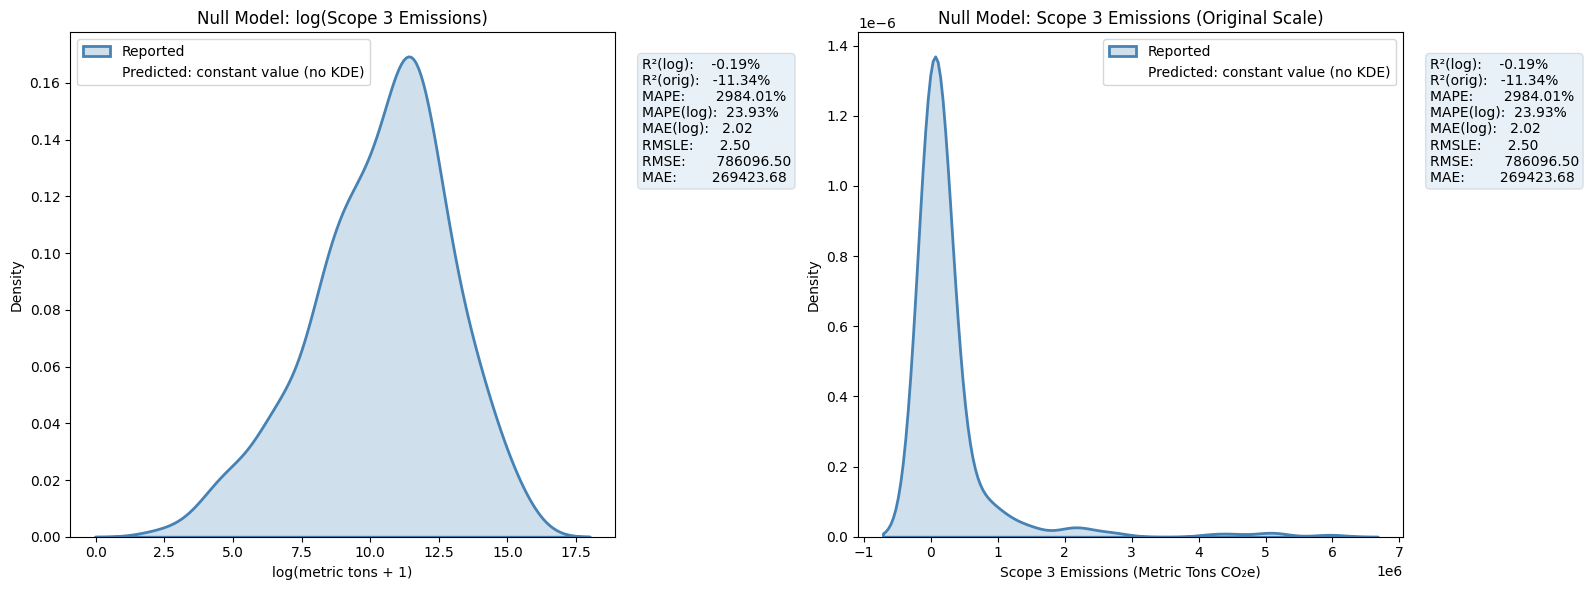

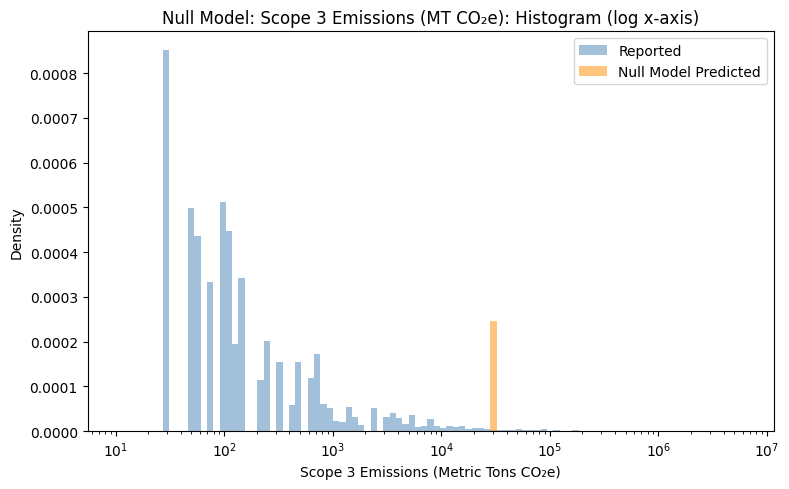

In [18]:
# --- Ensure log_Scope_3_emissions_amount exists (if not, create it) ---
if 'log_Scope_3_emissions_amount' not in train_df.columns:
    train_df['log_Scope_3_emissions_amount'] = np.log1p(train_df['Scope_3_emissions_amount'])
if 'log_Scope_3_emissions_amount' not in test_df.columns:
    test_df['log_Scope_3_emissions_amount'] = np.log1p(test_df['Scope_3_emissions_amount'])

# --- FIT THE NULL MODEL (random intercept only) ---
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    null_model = smf.mixedlm(
        "log_Scope_3_emissions_amount ~ 1",
        train_df,
        groups=train_df["account_id"]
    )
    null_result = null_model.fit(method="lbfgs")

if not null_result.converged:
    print("WARNING: Null model did not fully converge.")

print(null_result.summary())

# --- PREDICT ON TEST SET ---
test_df = test_df.copy()
test_df['predicted_null'] = null_result.predict(test_df)

# --- METRICS ---
y_true_log = test_df['log_Scope_3_emissions_amount']
y_pred_log = test_df['predicted_null']

# Remove inf/nan for robust metrics
mask = np.isfinite(y_true_log) & np.isfinite(y_pred_log)
y_true_log = y_true_log[mask]
y_pred_log = y_pred_log[mask]
test_df = test_df.loc[mask].copy()

# Log-scale MAPE
mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100

# Back-transform for original scale metrics
test_df['Reported_Scope_3'] = np.expm1(test_df['log_Scope_3_emissions_amount'])
test_df['Predicted_Scope_3'] = np.expm1(test_df['predicted_null'])
y_true = test_df['Reported_Scope_3']
y_pred = test_df['Predicted_Scope_3']

# Remove inf/nan for robust metrics
mask2 = np.isfinite(y_true) & np.isfinite(y_pred)
y_true = y_true[mask2]
y_pred = y_pred[mask2]

# Metrics calculations
r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
r2_orig_pct = r2_score(y_true, y_pred) * 100
mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
mae_orig = mean_absolute_error(y_true, y_pred)
mae_log = mean_absolute_error(y_true_log, y_pred_log)  # <--- MAE for log-transformed emissions

# Print metrics text
metrics_text = (
    f"R²(log):    {r2_log_pct:.2f}%\n"
    f"R²(orig):   {r2_orig_pct:.2f}%\n"
    f"MAPE:       {mape_orig:.2f}%\n"
    f"MAPE(log):  {mape_log:.2f}%\n"
    f"MAE(log):   {mae_log:.2f}\n"
    f"RMSLE:      {rmsle:.2f}\n"
    f"RMSE:       {rmse_orig:.2f}\n"
    f"MAE:        {mae_orig:.2f}"
)
print(metrics_text)

# --- VISUALIZATION ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Density plot on log scale
if y_pred_log.nunique() > 1:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
    sns.kdeplot(y_pred_log, label='Null Model Predicted', linewidth=2, fill=True, ax=axes[0], color='gray')
else:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
    axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
axes[0].set_title("Null Model: log(Scope 3 Emissions)")
axes[0].set_xlabel("log(metric tons + 1)")
axes[0].set_ylabel("Density")
axes[0].legend()

axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
             verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

# 2. Density plot on original scale
if y_pred.nunique() > 1:
    sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
    sns.kdeplot(y_pred, label='Null Model Predicted', linewidth=2, fill=True, ax=axes[1], color='gray')
else:
    sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
    axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
axes[1].set_title("Null Model: Scope 3 Emissions (Original Scale)")
axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
axes[1].set_ylabel("Density")
axes[1].legend()

axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
             verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

plt.tight_layout()
plt.show()

# Histogram on original scale with log x-axis
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)

plt.figure(figsize=(8, 5))
sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="Null Model Predicted")
plt.xscale("log")
plt.title("Null Model: Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# --- RETURN METRICS FOR SUMMARY TABLE ---
null_model_metrics = {
    "Model": "Null (RI)",
    "R2_log": r2_log_pct / 100,
    "R2_orig": r2_orig_pct / 100,
    "RMSE": rmse_orig,
    "MAE": mae_orig,
    "RMSLE": rmsle,
    "MAPE": mape_orig,
    "MAE_log": mae_log,  # <--- include MAE for log-transformed emissions
    "Notes": "Random intercept only"
}

## Downstream Two-Level Mixed-Effects Model

Two-level hierarchical linear mixed-effects model to predict log-transformed Scope 3 emissions at the company level. The model is fit to training data (from 2018–2022), and predictions are evaluated on a test set (from 2023).  This model provides a baseline for including time trends and company-level variability.
 
Model Structure:
- Random Effects:
    - Random intercept for each company ('account_id'), capturing baseline differences between companies.<br>
- Fixed Effects:
    - Year (numeric)
    - Year squared ('Year_sq', quadratic time trend)

Two-Level Model: Company/year group size summary:
count    434.000000
mean       3.755760
std        1.533393
min        1.000000
25%        2.000000
50%        5.000000
75%        5.000000
max        5.000000
dtype: float64
                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_Scope_3_emissions_amount
No. Observations: 1630    Method:             REML                        
No. Groups:       434     Scale:              0.7750                      
Min. group size:  1       Log-Likelihood:     -2834.8945                  
Max. group size:  5       Converged:          No                          
Mean group size:  3.8                                                     
----------------------------------------------------------------------------
              Coef.      Std.Err.     z      P>|z|     [0.025       0.975]  
----------------------------------------------------------------------------
Intercept   40020.915   55632.444    0

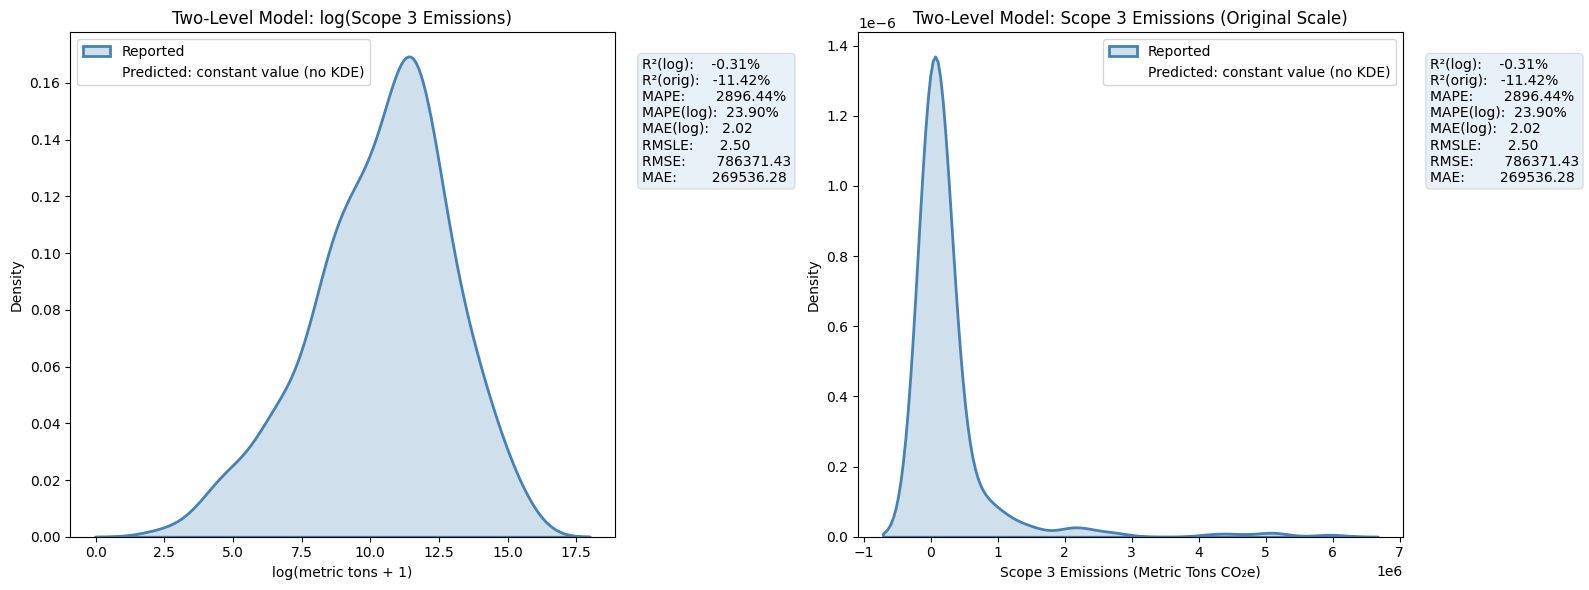

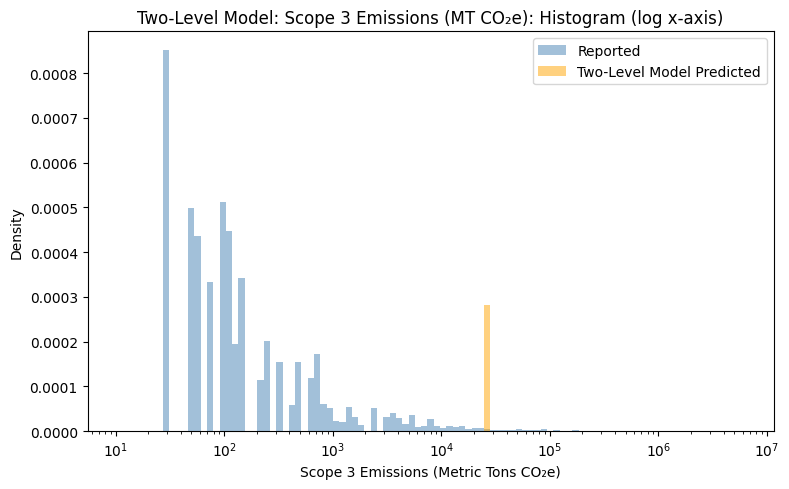

In [19]:
# --- Ensure log_Scope_3_emissions_amount exists (if not, create it) ---
if 'log_Scope_3_emissions_amount' not in train_df.columns:
    train_df['log_Scope_3_emissions_amount'] = np.log1p(train_df['Scope_3_emissions_amount'])
if 'log_Scope_3_emissions_amount' not in test_df.columns:
    test_df['log_Scope_3_emissions_amount'] = np.log1p(test_df['Scope_3_emissions_amount'])

# --- Check group sizes ---
group_sizes = train_df.groupby('account_id').size()
print("Two-Level Model: Company/year group size summary:")
print(group_sizes.describe())

# --- FIT THE TWO-LEVEL MODEL (random intercept, +Year, +Year_sq) ---
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    model = smf.mixedlm(
        "log_Scope_3_emissions_amount ~ Year + Year_sq",
        train_df,
        groups=train_df["account_id"],
        re_formula="1"
    )
    result_twolevel = model.fit(method="lbfgs")

if not result_twolevel.converged:
    print("WARNING: Two-level mixed model did not fully converge.")

print(result_twolevel.summary())

# --- PREDICT ON TEST SET ---
test_df = test_df.copy()
test_df['predicted_mixed'] = result_twolevel.predict(test_df)

# --- METRICS ---
y_true_log = test_df['log_Scope_3_emissions_amount']
y_pred_log = test_df['predicted_mixed']

# Remove inf/nan for robust metrics
mask = np.isfinite(y_true_log) & np.isfinite(y_pred_log)
y_true_log = y_true_log[mask]
y_pred_log = y_pred_log[mask]
test_df = test_df.loc[mask].copy()

# Log-scale MAPE
mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100

# Back-transform for original scale metrics
test_df['Reported_Scope_3'] = np.expm1(test_df['log_Scope_3_emissions_amount'])
test_df['Predicted_Scope_3'] = np.expm1(test_df['predicted_mixed'])
y_true = test_df['Reported_Scope_3']
y_pred = test_df['Predicted_Scope_3']

# Remove inf/nan for robust metrics
mask2 = np.isfinite(y_true) & np.isfinite(y_pred)
y_true = y_true[mask2]
y_pred = y_pred[mask2]

# Metrics calculations
r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
r2_orig_pct = r2_score(y_true, y_pred) * 100
mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
mae_orig = mean_absolute_error(y_true, y_pred)
mae_log = mean_absolute_error(y_true_log, y_pred_log)  # <--- MAE for log-transformed emissions

# Print metrics
metrics_text = (
    f"R²(log):    {r2_log_pct:.2f}%\n"
    f"R²(orig):   {r2_orig_pct:.2f}%\n"
    f"MAPE:       {mape_orig:.2f}%\n"
    f"MAPE(log):  {mape_log:.2f}%\n"
    f"MAE(log):   {mae_log:.2f}\n"
    f"RMSLE:      {rmsle:.2f}\n"
    f"RMSE:       {rmse_orig:.2f}\n"
    f"MAE:        {mae_orig:.2f}"
)
print(metrics_text)

# --- VISUALIZATION ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Density plot on log scale
if y_pred_log.nunique() > 1:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
    sns.kdeplot(y_pred_log, label='Two-Level Model Predicted', linewidth=2, fill=True, ax=axes[0], color='orange')
else:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
    axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
axes[0].set_title("Two-Level Model: log(Scope 3 Emissions)")
axes[0].set_xlabel("log(metric tons + 1)")
axes[0].set_ylabel("Density")
axes[0].legend()

axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
             verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

# 2. Density plot on original scale
if y_pred.nunique() > 1:
    sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
    sns.kdeplot(y_pred, label='Two-Level Model Predicted', linewidth=2, fill=True, ax=axes[1], color='orange')
else:
    sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
    axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
axes[1].set_title("Two-Level Model: Scope 3 Emissions (Original Scale)")
axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
axes[1].set_ylabel("Density")
axes[1].legend()

axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
             verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

plt.tight_layout()
plt.show()

# Histogram on original scale with log x-axis
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)

plt.figure(figsize=(8, 5))
sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
sns.histplot(y_pred, bins=log_bins, stat="density", color="orange", alpha=0.5, label="Two-Level Model Predicted")
plt.xscale("log")
plt.title("Two-Level Model: Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# --- RETURN METRICS FOR SUMMARY TABLE ---
two_level_model_metrics = {
    "Model": "2-level (RI+S)",
    "R2_log": r2_log_pct / 100,
    "R2_orig": r2_orig_pct / 100,
    "RMSE": rmse_orig,
    "MAE": mae_orig,
    "RMSLE": rmsle,
    "MAPE": mape_orig,
    "MAE_log": mae_log,  # <--- include MAE for log-transformed emissions
    "Notes": "+Year, Year_sq"
}

## Downstream Three-Level Mixed-Effects Model

A three-level hierarchical linear mixed-effects model is used to predict log-transformed Scope 3 emissions. It takes into account differences between primary activity, differences between companies, and changes over time. The model is trained using data from 2018 to 2022, and then tested on new data from 2023. This model provides insight on how emissions are influenced by primary activity, by individual companies, by financial and emissions factors, and by trends over time.

Model Structure:

- Level 3 (Primary Activity):<br>
    - Random intercept and random slope for Year for each primary activity ('Primary_activity'), capturing baseline primary activity and primary activity-specific time trends.<br>
- Level 2 (Account/Company):
    - Random intercept for each company ('account_id'), capturing company-level deviations within each primary activity.
- Level 1 (Yearly Observations):
    - Repeated annual observations within each company.

- Fixed Effects:
    - Signed log-transformed market cap ('slog_Market_Cap_USD')
    - Signed log-transformed revenue ('slog_Revenue_USD')
    - Signed log-transformed EBITDA ('slog_ebitda_USD')
    - Signed log-transformed Scope 1 & 2 emissions ('slog_scope_1_2_emissions_amount')

                     Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  log_Scope_3_emissions_amount
No. Observations:    1630     Method:              REML                        
No. Groups:          104      Scale:               0.6749                      
Min. group size:     1        Log-Likelihood:      -2747.5080                  
Max. group size:     105      Converged:           No                          
Mean group size:     15.7                                                      
-------------------------------------------------------------------------------
                                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------
Intercept                             2.185    1.239  1.763 0.078 -0.244  4.613
slog_Market_Cap_USD                   0.240    0.052  4.633 0.000  0.138  0.341
slog_Revenue_USD                      0.029    0.026  1.082 0

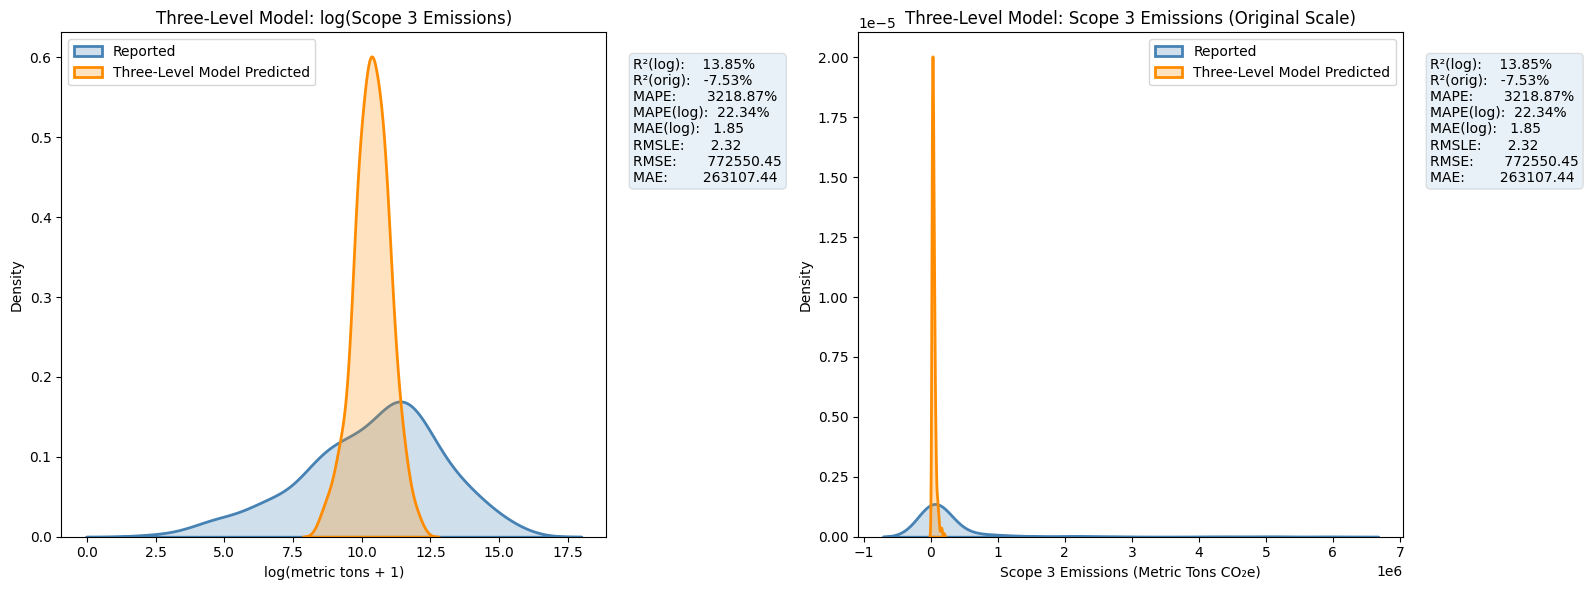

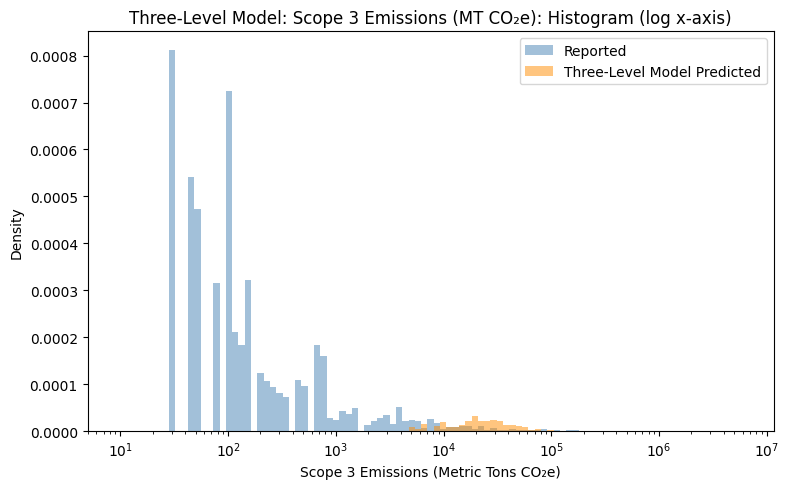

In [20]:
# --- Ensure grouping/categorical variables are string ---
for col in ['Countries', 'account_id', 'Primary_activity', 'Primary_sector']:
    train_df[col] = train_df[col].astype(str)
    test_df[col] = test_df[col].astype(str)

# --- Center the Year variable ---
year_mean = train_df['Year'].mean()
train_df['Year_centered'] = train_df['Year'] - year_mean
test_df['Year_centered'] = test_df['Year'] - year_mean

# --- Ensure log-transformed target exists ---
if 'log_Scope_3_emissions_amount' not in train_df.columns:
    train_df['log_Scope_3_emissions_amount'] = np.log1p(train_df['Scope_3_emissions_amount'])
if 'log_Scope_3_emissions_amount' not in test_df.columns:
    test_df['log_Scope_3_emissions_amount'] = np.log1p(test_df['Scope_3_emissions_amount'])

# --- FIT THE 3-LEVEL MIXED MODEL with Primary_activity as Level 3 group ---
vc = {'account_id': '0 + C(account_id)'}  # Level 2: account_id random intercept

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    model_3level = MixedLM.from_formula(
        'log_Scope_3_emissions_amount ~ slog_Market_Cap_USD + slog_Revenue_USD + slog_ebitda_USD + slog_scope_1_2_emissions_amount',
        groups='Primary_activity',
        re_formula='~Year_centered',
        vc_formula=vc,
        data=train_df
    )
    result_3level = model_3level.fit(method="lbfgs", maxiter=1000)

if not result_3level.converged:
    print("WARNING: Three-level mixed model did not fully converge.")

print(result_3level.summary())

# --- PREDICT ON TEST SET ---
test_df = test_df.copy()
test_df['predicted_mixed'] = result_3level.predict(test_df)

# --- Compute back-transformed values ---
test_df['Reported_Scope_3'] = np.expm1(test_df['log_Scope_3_emissions_amount'])
test_df['Predicted_Scope_3'] = np.expm1(test_df['predicted_mixed'])

# --- Robust Mask for finite values everywhere ---
mask = (
    np.isfinite(test_df['log_Scope_3_emissions_amount']) &
    np.isfinite(test_df['predicted_mixed']) &
    np.isfinite(test_df['Reported_Scope_3']) &
    np.isfinite(test_df['Predicted_Scope_3'])
)
test_df = test_df.loc[mask].copy()

y_true_log = test_df['log_Scope_3_emissions_amount'].values
y_pred_log = test_df['predicted_mixed'].values
y_true = test_df['Reported_Scope_3'].values
y_pred = test_df['Predicted_Scope_3'].values

# Final defensive check and diagnostics
arrays = {
    "y_true_log": y_true_log,
    "y_pred_log": y_pred_log,
    "y_true": y_true,
    "y_pred": y_pred,
}
for arr_name, arr in arrays.items():
    if not np.all(np.isfinite(arr)):
        print(f"ERROR: {arr_name} contains non-finite values!")
        print(f"Non-finite indices: {np.where(~np.isfinite(arr))[0]}")
        print(f"Values: {arr[~np.isfinite(arr)]}")
        raise ValueError(f"{arr_name} contains infs or NaNs after masking!")

# --- METRICS ---
mae_log = mean_absolute_error(y_true_log, y_pred_log)
nonzero_mask = y_true_log != 0
if np.any(nonzero_mask):
    mape_log = np.mean(np.abs((y_true_log[nonzero_mask] - y_pred_log[nonzero_mask]) / y_true_log[nonzero_mask])) * 100
else:
    mape_log = np.nan

r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
r2_pct = r2_score(y_true, y_pred) * 100
mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
mae_orig = mean_absolute_error(y_true, y_pred)

metrics_text = (
    f"R²(log):    {r2_log_pct:.2f}%\n"
    f"R²(orig):   {r2_pct:.2f}%\n"
    f"MAPE:       {mape_orig:.2f}%\n"
    f"MAPE(log):  {mape_log:.2f}%\n"
    f"MAE(log):   {mae_log:.2f}\n"
    f"RMSLE:      {rmsle:.2f}\n"
    f"RMSE:       {rmse_orig:.2f}\n"
    f"MAE:        {mae_orig:.2f}"
)
print(metrics_text)

# --- VISUALIZATION ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
if len(np.unique(y_pred_log)) > 1:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
    sns.kdeplot(y_pred_log, label='Three-Level Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
else:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
    axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
axes[0].set_title("Three-Level Model: log(Scope 3 Emissions)")
axes[0].set_xlabel("log(metric tons + 1)")
axes[0].set_ylabel("Density")
axes[0].legend()
axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
             verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

if len(np.unique(y_pred)) > 1:
    sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
    sns.kdeplot(y_pred, label='Three-Level Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
else:
    sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
    axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
axes[1].set_title("Three-Level Model: Scope 3 Emissions (Original Scale)")
axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
axes[1].set_ylabel("Density")
axes[1].legend()
axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
             verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

plt.tight_layout()
plt.show()

# Filter strictly positive values for histogram (log x-axis requires >0)
y_true_pos = y_true[y_true > 0]
y_pred_pos = y_pred[y_pred > 0]

if y_true_pos.size > 0 and y_pred_pos.size > 0:
    min_val = min(y_true_pos.min(), y_pred_pos.min())
    max_val = max(y_true_pos.max(), y_pred_pos.max())
    if min_val == max_val:
        print("Skipping histogram: Only one unique positive value present.")
    else:
        log_bins = np.logspace(np.log10(min_val), np.log10(max_val), 100)

        plt.figure(figsize=(8, 5))
        sns.histplot(y_true_pos, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
        sns.histplot(y_pred_pos, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="Three-Level Model Predicted")
        plt.xscale("log")
        plt.title("Three-Level Model: Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
        plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
        plt.ylabel("Density")
        plt.legend()
        plt.tight_layout()
        plt.show()
else:
    print("Skipping histogram: Not enough positive values in y_true or y_pred for log-scale histogram.")

# --- RETURN METRICS FOR SUMMARY TABLE ---
three_level_model_metrics = {
    "Model": "3-level (Primary Activity/Account/Year)",
    "R2_log": r2_log_pct / 100,
    "R2_orig": r2_pct / 100,
    "RMSE": rmse_orig,
    "MAE": mae_orig,
    "RMSLE": rmsle,
    "MAPE": mape_orig,
    "MAE_log": mae_log,
    "MAPE(log)": mape_log,
}

## Downstream Full Mixed-Effects Model

A full mixed-effects model is used to predict company Scope 3 emissions, using financial and emissions data, along with information about country, industry, and year. The model is trained on data from 2018 to 2022, and tested on data from 2023. This full model helps provides insights into how a company’s finances, emissions, primary activity, country and the year influence emissions.<br>

Model Structure:<br>

- Random Effects:<br>
    - Random intercept for each company ('account_id'), capturing company-level baseline differences
- Fixed Effects:<br>
    - Signed log-transformed financial and emissions features:<br>
        - Market Cap ('slog_Market_Cap_USD')<br>
        - Revenue ('slog_Revenue_USD')<br>
        - EBITDA ('slog_ebitda_USD')<br>
        - Total Investments ('slog_totalInvestments_USD')<br>
        - Total Debt ('slog_totalDebt_USD')<br>
        - Total Assets ('slog_totalAssets_USD')<br>
        - Total Liabilities ('slog_totalLiabilities_USD')<br>
        - Total Equity ('slog_totalEquity_USD')<br>
        - Scope 1&2 Emissions ('slog_scope_1_2_emissions_amount')<br>
    - Country ('Countries', as a categorical variable)<br>
    - Primary Activity ('Primary_activity', as a categorical variable)<br>
    - Year (numeric)<br>

                                         Mixed Linear Model Regression Results
Model:                            MixedLM               Dependent Variable:               slog_Scope_3_emissions_amount
No. Observations:                 1630                  Method:                           ML                           
No. Groups:                       434                   Scale:                            0.7815                       
Min. group size:                  1                     Log-Likelihood:                   -2625.9079                   
Max. group size:                  5                     Converged:                        Yes                          
Mean group size:                  3.8                                                                                  
-----------------------------------------------------------------------------------------------------------------------
                                                                           Coef. 

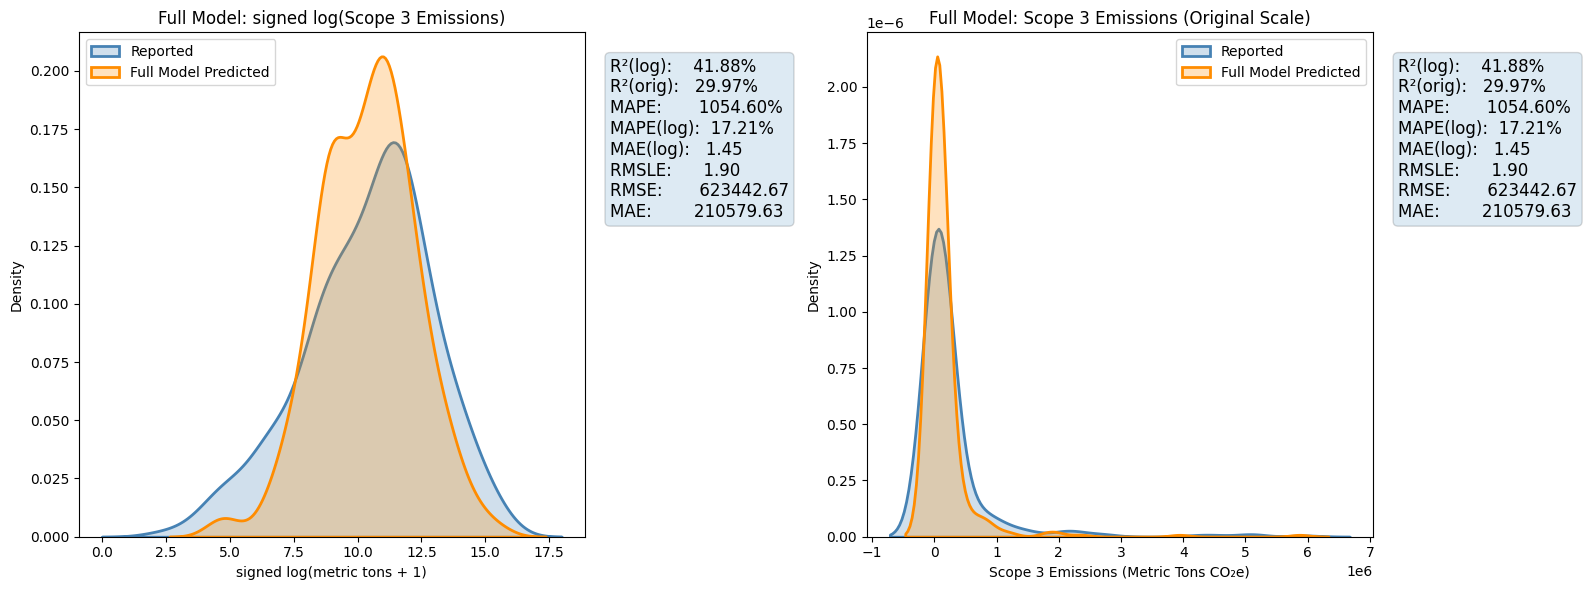

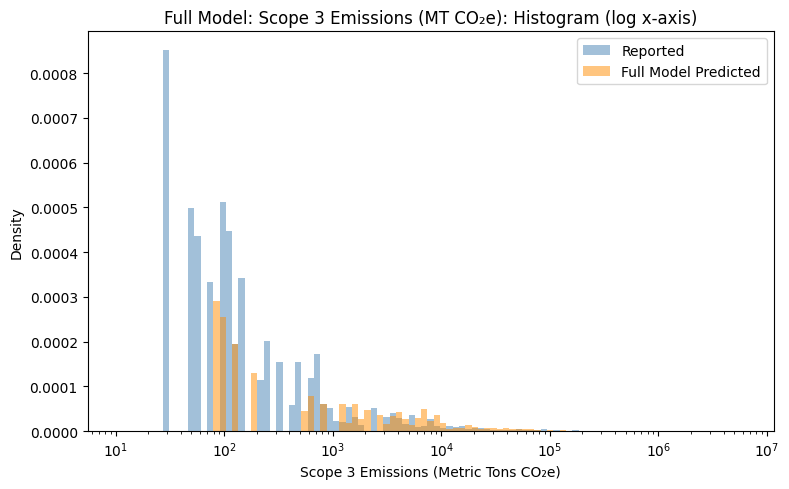

In [21]:
# --- Feature and target columns ---
numeric_cols = ['Market_Cap_USD',
 'Revenue_USD',
 'ebitda_USD',
 'totalAssets_USD',
 'totalLiabilities_USD',
 'totalInvestments_USD',
 'totalDebt_USD',
 'totalEquity_USD',
 'Scope_3_emissions_amount',
 'scope_1_2_emissions_amount'
]
feature_cols_slog = [f'slog_{col}' for col in numeric_cols if col != 'Scope_3_emissions_amount']
target_col_slog = 'slog_Scope_3_emissions_amount'

# --- Filter for required columns only ---
required_cols = feature_cols_slog + [target_col_slog, 'Countries', 'Year', 'account_id', 'Primary_activity']
train_df_full = train_df.dropna(subset=required_cols).copy()
test_df_full = test_df.dropna(subset=required_cols).copy()

if test_df_full.empty:
    print("WARNING: The filtered test set is empty. No predictions or metrics can be computed.")
else:
    # --- Model formula ---
    fixed_effects = (
        ' + '.join(feature_cols_slog) +
        ' + C(Countries) + C(Primary_activity) + Year'
    )
    formula = f'{target_col_slog} ~ {fixed_effects}'

    # --- Fit the full mixed-effects model ---
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        md = smf.mixedlm(formula, data=train_df_full, groups=train_df_full['account_id'])
        mdf = md.fit(reml=False)
    print(mdf.summary())

    # --- Predict on test set ---
    test_df_full['predicted_log'] = mdf.predict(test_df_full)
    test_df_full['predicted'] = np.sign(test_df_full['predicted_log']) * (np.expm1(np.abs(test_df_full['predicted_log'])))

    # --- Metrics ---
    y_true_log = test_df_full[target_col_slog]
    y_pred_log = test_df_full['predicted_log']
    y_true = np.sign(y_true_log) * (np.expm1(np.abs(y_true_log)))
    y_pred = test_df_full['predicted']

    # Mask for finite values
    mask = (
        np.isfinite(y_true_log) & np.isfinite(y_pred_log) &
        np.isfinite(y_true) & np.isfinite(y_pred)
    )
    y_true_log = y_true_log[mask]
    y_pred_log = y_pred_log[mask]
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    # Metrics calculations
    r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
    r2_pct = r2_score(y_true, y_pred) * 100
    mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100
    mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_orig = mean_absolute_error(y_true, y_pred)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)  # <--- MAE for log-transformed emissions

    metrics_text = (
        f"R²(log):    {r2_log_pct:.2f}%\n"
        f"R²(orig):   {r2_pct:.2f}%\n"
        f"MAPE:       {mape_orig:.2f}%\n"
        f"MAPE(log):  {mape_log:.2f}%\n"
        f"MAE(log):   {mae_log:.2f}\n"
        f"RMSLE:      {rmsle:.2f}\n"
        f"RMSE:       {rmse_orig:.2f}\n"
        f"MAE:        {mae_orig:.2f}"
    )

    print("\nFull Mixed-Effects Model (Full Model) Test Set Performance Metrics:")
    print(metrics_text)

    # --- Feature coefficients ---
    coef_df = pd.DataFrame({
        'coef': mdf.params,
        'pvalue': mdf.pvalues
    }).drop(index="Intercept", errors='ignore').sort_values(by="pvalue")
    print("\nTop Influential Features (by p-value):")
    print(coef_df.head(10))

    # --- VISUALIZATION ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # 1. Density plot on log scale
    if y_pred_log.nunique() > 1:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        sns.kdeplot(y_pred_log, label='Full Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
    else:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[0].set_title("Full Model: signed log(Scope 3 Emissions)")
    axes[0].set_xlabel("signed log(metric tons + 1)")
    axes[0].set_ylabel("Density")
    axes[0].legend()

    axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))

    # 2. Density plot on original scale
    if y_pred.nunique() > 1:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        sns.kdeplot(y_pred, label='Full Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
    else:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[1].set_title("Full Model: Scope 3 Emissions (Original Scale)")
    axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    axes[1].set_ylabel("Density")
    axes[1].legend()

    axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))

    plt.tight_layout()
    plt.show()

    # Histogram on original scale with log x-axis
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)

    plt.figure(figsize=(8, 5))
    sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
    sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="Full Model Predicted")
    plt.xscale("log")
    plt.title("Full Model: Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
    plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- RETURN METRICS FOR SUMMARY TABLE ---
    full_model_metrics = {
        "Model": "Full Model",
        "R2_log": r2_log_pct / 100,
        "R2_orig": r2_pct / 100,
        "RMSE": rmse_orig,
        "MAE": mae_orig,
        "RMSLE": rmsle,
        "MAPE": mape_orig,
        "MAE_log": mae_log
    }

## Downstream Optimized Mixed-Effects Model

An optimized mixed-effects model is used to predict company Scope 3 emissions. The model provides accurate prediction using only the most significant predictive features, while still accounting for primary activity, country and company level effects. The model is trained on data from 2018–2022 and evaluated on test data from 2023.

Model Structure:

- Random Effects:
    - Random intercept for each company ('account_id'), capturing company-level baseline differences
- Fixed Effects:
    - Signed log-transformed features:
        - Market Cap ('slog_Market_Cap_USD')
        - Revenue ('slog_Revenue_USD')
        - Total Assets ('slog_totalAssets_USD')
        - Scope 1 & 2 Emissions ('slog_scope_1_2_emissions_amount')
    - Country ('Countries', as a categorical variable)
    - Primary Activity ('Primary_activity', as a categorical variable)

                                       Mixed Linear Model Regression Results
Model:                           MixedLM              Dependent Variable:              slog_Scope_3_emissions_amount
No. Observations:                1630                 Method:                          ML                           
No. Groups:                      434                  Scale:                           0.7878                       
Min. group size:                 1                    Log-Likelihood:                  -2632.5267                   
Max. group size:                 5                    Converged:                       Yes                          
Mean group size:                 3.8                                                                                
--------------------------------------------------------------------------------------------------------------------
                                                                          Coef.  Std.Err.   z    P>|z| [

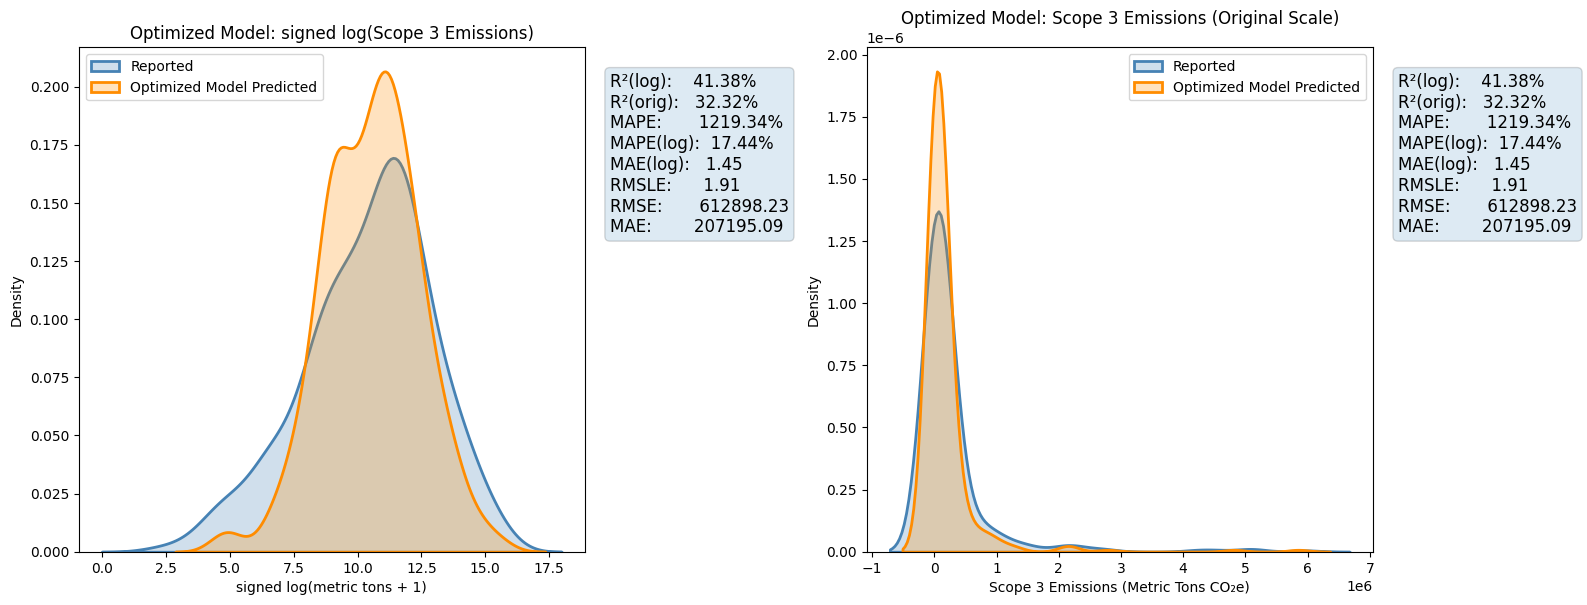

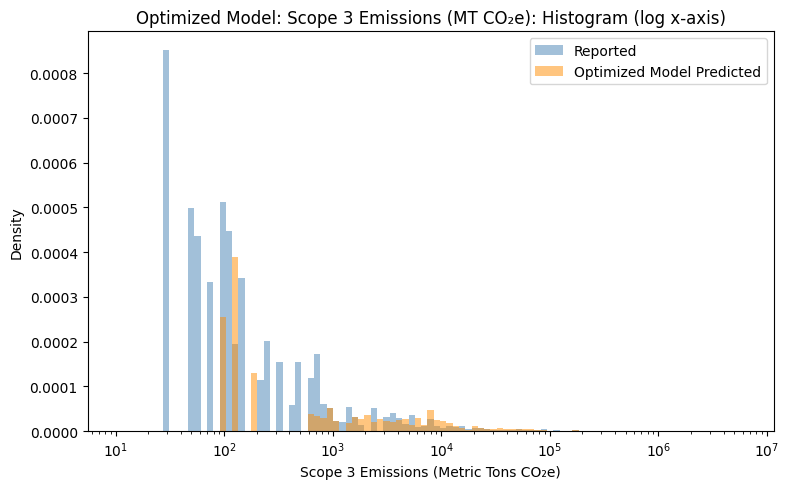

In [22]:
feature_cols_slog = [
    'slog_Market_Cap_USD',
    'slog_Revenue_USD',
    'slog_totalAssets_USD',
    'slog_totalLiabilities_USD',
    'slog_scope_1_2_emissions_amount'
]
target_col_slog = 'slog_Scope_3_emissions_amount'

# --- Filter for required columns only ---
all_model_vars = feature_cols_slog + [target_col_slog, 'Countries', 'Year', 'account_id', 'Primary_activity']
train_df_opt = train_df.dropna(subset=all_model_vars).copy()
test_df_opt = test_df.dropna(subset=all_model_vars).copy()

if test_df_opt.empty:
    print("WARNING: The filtered test set is empty. No predictions or metrics can be computed.")
else:
    # --- Model formula ---
    fixed_effects = (
        ' + '.join(feature_cols_slog) +
        ' + C(Countries) + C(Primary_activity)'
    )
    formula = f'{target_col_slog} ~ {fixed_effects}'

    # --- Fit the optimized mixed-effects model ---
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        md = smf.mixedlm(formula, data=train_df_opt, groups=train_df_opt['account_id'])
        mdf_optimized = md.fit(reml=False)
    print(mdf_optimized.summary())

    # --- Predict on test set ---
    test_df_opt['predicted_log'] = mdf_optimized.predict(test_df_opt)
    test_df_opt['predicted'] = np.sign(test_df_opt['predicted_log']) * (np.expm1(np.abs(test_df_opt['predicted_log'])))

    # --- Metrics ---
    y_true_log = test_df_opt[target_col_slog]
    y_pred_log = test_df_opt['predicted_log']
    y_true = np.sign(y_true_log) * (np.expm1(np.abs(y_true_log)))
    y_pred = test_df_opt['predicted']

    # Mask for valid/finites
    mask = (
        np.isfinite(y_true_log) & np.isfinite(y_pred_log) &
        np.isfinite(y_true) & np.isfinite(y_pred)
    )
    y_true_log = y_true_log[mask]
    y_pred_log = y_pred_log[mask]
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    # Metrics calculations
    r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
    r2_pct = r2_score(y_true, y_pred) * 100
    mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100
    mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_orig = mean_absolute_error(y_true, y_pred)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)  # <-- MAE for log-transformed emissions

    metrics_text = (
        f"R²(log):    {r2_log_pct:.2f}%\n"
        f"R²(orig):   {r2_pct:.2f}%\n"
        f"MAPE:       {mape_orig:.2f}%\n"
        f"MAPE(log):  {mape_log:.2f}%\n"
        f"MAE(log):   {mae_log:.2f}\n"
        f"RMSLE:      {rmsle:.2f}\n"
        f"RMSE:       {rmse_orig:.2f}\n"
        f"MAE:        {mae_orig:.2f}"
    )

    print("\nOptimized Mixed-Effects Model: Test Set Performance Metrics:")
    print(metrics_text)

    # --- Feature coefficients ---
    coef_df = pd.DataFrame({
        'coef': mdf_optimized.params,
        'pvalue': mdf_optimized.pvalues
    }).drop(index="Intercept", errors='ignore').sort_values(by="pvalue")
    print("\nTop Influential Features (by p-value):")
    print(coef_df.head(10))

    print("\nAll feature coefficients sorted by absolute value:")
    print(coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index))

    # --- VISUALIZATION ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # 1. Density plot on log scale
    if y_pred_log.nunique() > 1:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        sns.kdeplot(y_pred_log, label='Optimized Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
    else:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[0].set_title("Optimized Model: signed log(Scope 3 Emissions)")
    axes[0].set_xlabel("signed log(metric tons + 1)")
    axes[0].set_ylabel("Density")
    axes[0].legend()

    axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))

    # 2. Density plot on original scale
    if y_pred.nunique() > 1:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        sns.kdeplot(y_pred, label='Optimized Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
    else:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[1].set_title("Optimized Model: Scope 3 Emissions (Original Scale)")
    axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    axes[1].set_ylabel("Density")
    axes[1].legend()

    axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))

    plt.tight_layout()
    plt.show()

    # Histogram on original scale with log x-axis
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)

    plt.figure(figsize=(8, 5))
    sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
    sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="Optimized Model Predicted")
    plt.xscale("log")
    plt.title("Optimized Model: Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
    plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- RETURN METRICS FOR SUMMARY TABLE ---
    optimized_model_metrics = {
        "Model": "Optimized",
        "R2_log": r2_log_pct / 100,
        "R2_orig": r2_pct / 100,
        "RMSE": rmse_orig,
        "MAE": mae_orig,
        "RMSLE": rmsle,
        "MAPE": mape_orig,
        "MAE_log": mae_log
    }

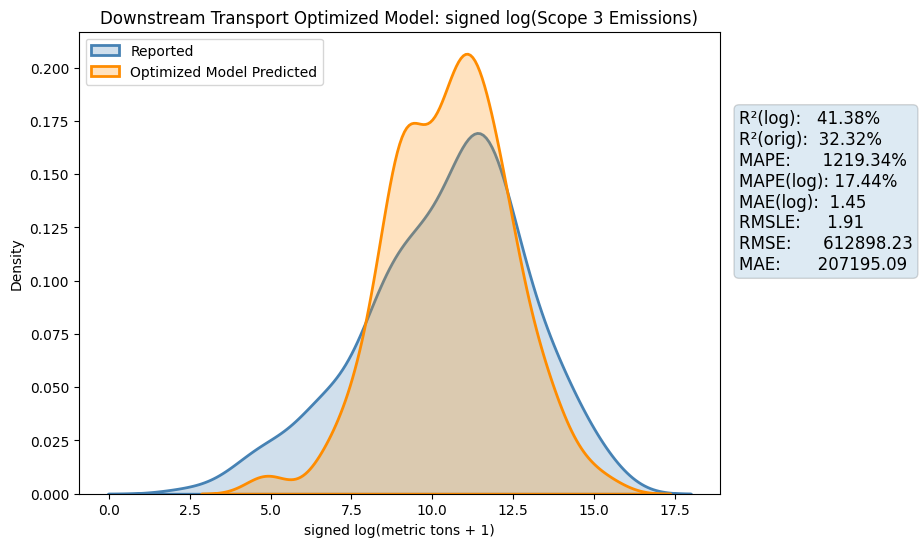

In [23]:
metrics_text_log = (
    f"R²(log):   {r2_log_pct:.2f}%\n"
    f"R²(orig):  {r2_pct:.2f}%\n"
    f"MAPE:      {mape_orig:.2f}%\n"
    f"MAPE(log): {mape_log:.2f}%\n"
    f"MAE(log):  {mae_log:.2f}\n"
    f"RMSLE:     {rmsle:.2f}\n"
    f"RMSE:      {rmse_orig:.2f}\n"
    f"MAE:       {mae_orig:.2f}"
)

fig, ax = plt.subplots(figsize=(9.5, 6))  # Wider to make room for the box

if hasattr(y_pred_log, "nunique"):
    multiple_vals = y_pred_log.nunique() > 1
else:
    multiple_vals = len(set(y_pred_log)) > 1

if multiple_vals:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=ax, color='steelblue')
    sns.kdeplot(y_pred_log, label='Optimized Model Predicted', linewidth=2, fill=True, ax=ax, color='darkorange')
else:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=ax, color='steelblue')
    ax.plot([], [], ' ', label="Predicted: constant value (no KDE)")

ax.set_title("Downstream Transport Optimized Model: signed log(Scope 3 Emissions)")
ax.set_xlabel("signed log(metric tons + 1)")
ax.set_ylabel("Density")
ax.legend()

# Place metrics box outside plot to the right
fig.text(
    0.82, 0.75, metrics_text_log,
    va='top', ha='left',
    fontsize=12, bbox=dict(boxstyle='round', alpha=0.15)
)

plt.subplots_adjust(right=0.8)  # Make sure there's room for the box
fig.savefig("downstream_transport_scope3_log_density.png", dpi=300, bbox_inches='tight')
plt.show()

# Metrics Table for Downstream Transportation

In [24]:
metrics_dicts = [
    null_model_metrics,
    two_level_model_metrics,
    three_level_model_metrics,
    full_model_metrics,
    optimized_model_metrics
]

for metrics, train, test in zip(
        metrics_dicts,
        [train_df, train_df, train_df, train_df, train_df],
        [test_df, test_df, test_df, test_df, test_df]):
    
    metrics["# Obs (train)"] = len(train)
    metrics["# Obs (test)"] = len(test)
    metrics["# Obs (train/test)"] = f"{len(train)}/{len(test)}"

metrics_df = pd.DataFrame(metrics_dicts)

# Ensure all relevant columns are ordered and present
desired_order = [
    "Model", "R2_log", "R2_orig", "RMSE", "MAE", "MAE_log", "RMSLE", "MAPE", "# Obs (train/test)"
]


# Ensure MAE_log is present, fill with NaN if missing
if "MAE_log" not in metrics_df.columns:
    metrics_df["MAE_log"] = np.nan

metrics_df = metrics_df[[col for col in desired_order if col in metrics_df.columns]]

metrics_df_display = metrics_df.copy()
if "R2_log" in metrics_df_display.columns:
    metrics_df_display["R2_log"] = (metrics_df_display["R2_log"] * 100).map("{:.2f}%".format)
if "R2_orig" in metrics_df_display.columns:
    metrics_df_display["R2_orig"] = (metrics_df_display["R2_orig"] * 100).map("{:.2f}%".format)
for col in ["RMSE", "MAE", "MAE_log", "RMSLE", "MAPE", "MAPE(log)"]:
    if col in metrics_df_display.columns:
        metrics_df_display[col] = metrics_df_display[col].map("{:.2f}".format)

from IPython.display import display
display(metrics_df_display)

,Model,R2_log,R2_orig,RMSE,MAE,MAE_log,RMSLE,MAPE,# Obs (train/test)
0,Null (RI),-0.19%,-11.34%,786096.50,269423.68,2.02,2.50,2984.01,1630/303
1,2-level (RI+S),-0.31%,-11.42%,786371.43,269536.28,2.02,2.50,2896.44,1630/303
2,3-level (Primary Activity/Account/Year),13.85%,-7.53%,772550.45,263107.44,1.85,2.32,3218.87,1630/303
3,Full Model,41.88%,29.97%,623442.67,210579.63,1.45,1.90,1054.60,1630/303
4,Optimized,41.38%,32.32%,612898.23,207195.09,1.45,1.91,1219.34,1630/303
